# Resnet 전이학습을 통해 이미지 분류 구현해보기

### 전반적인 과정
1. 데이터 다운로드
    - 꽃 데이터셋 다운로드 :"https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
2. 데이터셋 나누기, 전처리
    - tf.keras.utils.image_dataset_from_directory로 이미지 로드하여 train, val 셋 나눔
    - ResNet50의 스케일링 방법이 따로 있음
3. ResNet 불러오기
    - 학습시킬 레이어, 고정시킬 레이어 결정 후 compile해야 함
4. 모델 학습
    - 콜백 설정
    - model.fit
5. 평가 및 예측 결과 확인
    - 직접 test 데이터셋 만들어서 진행

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, get_file, image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from sklearn.model_selection import train_test_split

import random
import numpy as np
import matplotlib.pyplot as plt
import glob

## 1. 데이터 다운로드

In [2]:
import pathlib #OS에 상관없이 경로를 나타내고, 다룰 수 있는 클래스들을 정의하고 있음

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = get_file(origin = dataset_url,
                    fname = 'flower_photos',
                    untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 12s 0us/step


In [3]:
#이미지 개수 확인
img_cnt = len(list(data_dir.glob('*/*.jpg')))
print(img_cnt)

3670


/root/.keras/datasets/flower_photos/roses/6069602140_866eecf7c2_m.jpg
<class 'pathlib.PosixPath'>


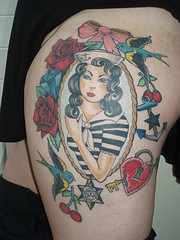

In [4]:
import PIL

roses = list(data_dir.glob('roses/*'))
print(roses[0]) 
print(type(roses[0])) #PosixPath타입의 경로이므로 
PIL.Image.open(str(roses[0])) #str(경로) 필수

## 2. 데이터셋 나누기 to train_ds,val_ds

In [5]:
img_h = 180
img_w = 180

In [7]:
## keras.utils.image_dataset_from_directory를 이용한 데이터분리
## default로 batch_size=32로 배치 생성
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 2023,
    image_size = (img_h,img_w)
)

val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
subset="validation",
  seed=2023,
  image_size=(img_h, img_w)
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
print(type(train_ds))
print(train_ds)
class_names = train_ds.class_names
print(train_ds.class_names) #5개의 클래스

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


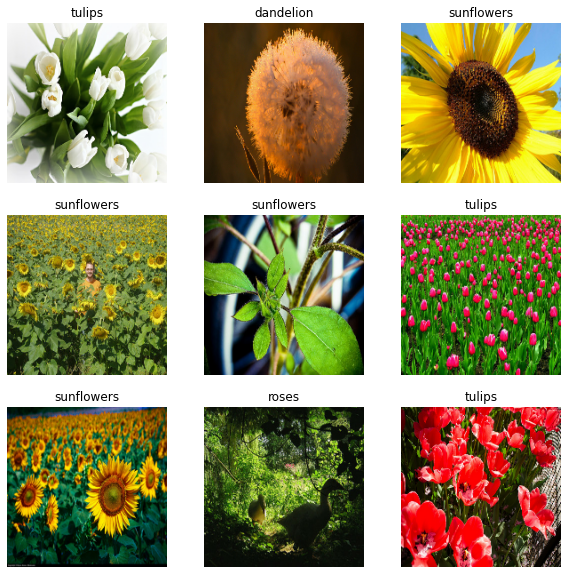

In [9]:
## 데이터 시각화 해보기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
#image_batch는 (32, 180, 180, 3) 형상의 텐서이며, 180x180x3 형상의 32개 이미지 묶음으로 되어 있습니다. 
#label_batch는 형상 (32,)의 텐서이며 32개 이미지에 해당하는 레이블입니다.
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch) #하나의 배치의 이미지들 대한 라벨들(32개)
    break # 한 배치에 대해서만 shape확인하면 됨

(32, 180, 180, 3)
(32,)
tf.Tensor([3 1 4 1 3 3 0 0 4 4 2 3 3 1 4 3 1 4 1 4 3 3 3 4 4 2 4 0 4 4 4 1], shape=(32,), dtype=int32)


In [11]:
train_normalized = train_ds.map(lambda x,y : (preprocess_input(x),y))
val_normalized = val_ds.map(lambda x,y : (preprocess_input(x),y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
#스케일링 확인하기 위한 작업들.. 우리가 결국 사용할 것은 normalized_ds
image_batch, labels_batch = next(iter(train_normalized))

In [13]:
print(image_batch.shape)
print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [14]:
#The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
np.min(image_batch[1]), np.max(image_batch[1]) #그래서 -1~1로 스케일링 되진 않음

(-123.68, 144.26654)

## 3. ResNet 불러오기

In [ ]:
###Functional API로 구성

#1. 세션 클리어
keras.backend.clear_session()

#2. base모델과 내가 만든 레이어 연결
base_model = ResNet50(weights = 'imagenet',
                      include_top = False,
                      input_shape = (img_h,img_w,3))
new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(5, #클래스5개!
                   activation = 'softmax')(new_output)

#3. 모델 input, output layer 지정
model = keras.models.Model(base_model.inputs,new_output)

model.summary()

In [16]:
print(f'모델 레이어 수: {len(model.layers)}')

모델 레이어 수: 177


#### ResNet에서 학습시킬 레이어, 고정시킬 레이어 결정! 
    - trainable 설정
    - model.compile

In [17]:
##'conv5_block1_1_conv'전까지만 다 동결, 이후는 다 학습o
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
#model compile
model.compile(loss = 'sparse_categorical_crossentropy', #원핫인코딩!
              optimizer = keras.optimizers.Adam(lr=0.001),
              metrics = ['accuracy'])

## 4. 모델 학습
    - 콜백 작성
    - fit

In [19]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=5, # 개선 없는 epoch 얼마나 기달려 줄거야
                   verbose=1,
                   restore_best_weights=True)

In [21]:
# 데이터를 넣어서 학습시키자!
history = model.fit(
    train_normalized,
    validation_data = val_normalized,
    epochs=1000,
    verbose = 1,
    callbacks = [es,lr_reduction]
)

Epoch 1/1000
92/92 [==============================] - 23s 52ms/step - loss: 0.4938 - accuracy: 0.8501 - val_loss: 44.3513 - val_accuracy: 0.5954 - lr: 0.0010
Epoch 2/1000
92/92 [==============================] - 3s 33ms/step - loss: 0.1239 - accuracy: 0.9666 - val_loss: 51.6662 - val_accuracy: 0.5518 - lr: 0.0010
Epoch 3/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0625 - accuracy: 0.9847 - val_loss: 3.8916 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 4/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0319 - accuracy: 0.9894 - val_loss: 0.3746 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 5/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0183 - accuracy: 0.9963 - val_loss: 0.2932 - val_accuracy: 0.9196 - lr: 0.0010
Epoch 6/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0206 - accuracy: 0.9963 - val_loss: 0.2637 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 7/1000
92/92 [==============================] - 3s 32ms

## 5. 예측 및 테스트
내가 수집한 테스트 데이터 불러와서 예측 해보기

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os

In [24]:
os.getcwd()

'/content'

In [25]:
os.chdir("/content/drive/MyDrive/my_data/")
os.getcwd()

'/content/drive/MyDrive/my_data'

In [29]:
import glob
from tensorflow.keras.preprocessing import image

files = glob.glob('flower_test/*') 
files

['flower_test/58_shop1_905939.jpg',
 'flower_test/77679866.jpg',
 'flower_test/daisy-flower-1532449822.jpg',
 'flower_test/GettyImages-521760299.jpg',
 'flower_test/download.jpg',
 'flower_test/9959_40365_3911.jpg',
 'flower_test/art_15935808035986_3abeb2.jpg',
 'flower_test/해바라기.jpg']

In [51]:
images = []

for path in files :
    img = image.load_img(path, grayscale = False, target_size = (img_h,img_w) )
    img = image.img_to_array(img)
    img = preprocess_input(img)
    images.append(img)
    
images = np.array(images)    #test_x
images_y = np.array([4, 2, 0, 1, 2, 1, 3, 3 ]) #test_y

In [52]:
#model 평가
result = model.evaluate(images,images_y)
result

1/1 [==============================] - 1s 970ms/step - loss: 0.1578 - accuracy: 1.0000


[0.15776970982551575, 1.0]

In [39]:
#예측 (확인)
features = model.predict(images)
features

1/1 [==============================] - 0s 33ms/step


array([[1.39575859e-03, 1.61922106e-03, 1.55078445e-03, 5.13198436e-04,
        9.94921029e-01],
       [7.86508754e-05, 3.20709689e-04, 9.99291778e-01, 2.44458672e-04,
        6.43923704e-05],
       [1.00000000e+00, 3.02231005e-12, 2.56193192e-11, 2.65226757e-10,
        1.85992027e-10],
       [3.05270478e-02, 5.21757662e-01, 3.96749645e-01, 1.17662512e-02,
        3.91993746e-02],
       [2.83067557e-03, 4.51325327e-01, 5.45782685e-01, 5.89825822e-06,
        5.54484213e-05],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.49937715e-09, 1.25088810e-08, 1.16295142e-11, 1.00000000e+00,
        1.53481121e-08],
       [3.96867381e-06, 2.59319495e-05, 2.26698263e-04, 9.99729097e-01,
        1.42701165e-05]], dtype=float32)

In [46]:
flower_dict = {}
for i in range(len(class_names)):
    flower_dict[i] = class_names[i]

flower_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

모델의 예측 : tulips
모델의 카테고리별 확률 : [ 0.  0.  0.  0. 99.]


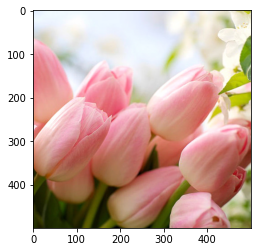

모델의 예측 : roses
모델의 카테고리별 확률 : [ 0.  0. 98.  0.  0.]


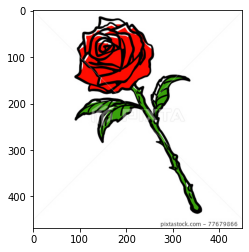

모델의 예측 : daisy
모델의 카테고리별 확률 : [99.  0.  0.  0.  0.]


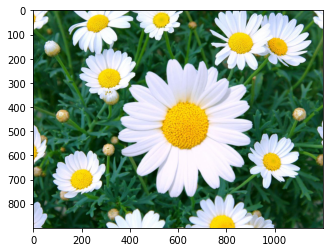

모델의 예측 : dandelion
모델의 카테고리별 확률 : [ 4. 58. 29.  4.  3.]


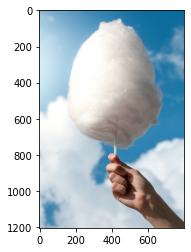

모델의 예측 : roses
모델의 카테고리별 확률 : [ 2. 11. 85.  0.  0.]


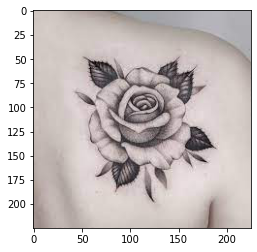

모델의 예측 : dandelion
모델의 카테고리별 확률 : [  0. 100.   0.   0.   0.]


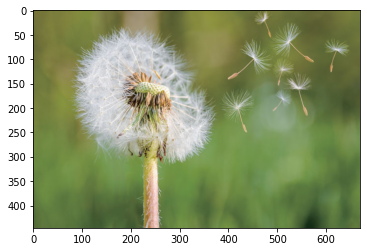

모델의 예측 : daisy
모델의 카테고리별 확률 : [52.  4.  0. 43.  0.]


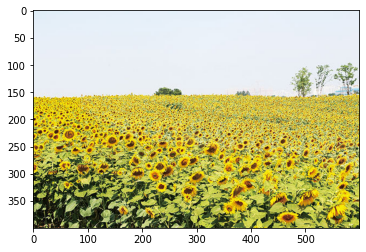

모델의 예측 : sunflowers
모델의 카테고리별 확률 : [ 3. 27. 29. 36.  2.]


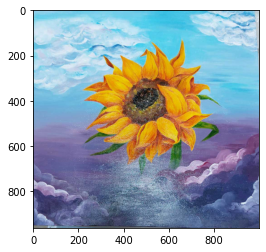

In [47]:
for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {flower_dict[pred[i].argmax()]}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')
    plt.imshow(image.load_img(files[i]))
    plt.show()


In [49]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']